In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from IPython.display import display


results_dir = Path('results/30 runs')
print(f"Reading from: {results_dir}\n")

benchmark_data = []

for file_path in results_dir.glob('*.csv'):
    parts = file_path.name.split('_')
    
    if len(parts) >= 2:
        tool_name = parts[0]
        mode_name = parts[1]
        
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                continue
            
            total_energy = None
            
            # Linux format (Cumulative Energy in Joules)
            if 'CPU_ENERGY (J)' in df.columns:
                df['CPU_ENERGY (J)'] = pd.to_numeric(df['CPU_ENERGY (J)'], errors='coerce')
                df = df.dropna(subset=['CPU_ENERGY (J)'])
                
                if not df.empty:
                    total_energy = df['CPU_ENERGY (J)'].iloc[-1] - df['CPU_ENERGY (J)'].iloc[0]
                
            # Mac format (Instantaneous Power in Watts)
            elif 'SYSTEM_POWER (Watts)' in df.columns and 'Time' in df.columns:
                # Force numeric conversion to fix the 'str' error
                df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
                df['SYSTEM_POWER (Watts)'] = pd.to_numeric(df['SYSTEM_POWER (Watts)'], errors='coerce')
                
                # Drop bad/corrupted rows
                df = df.dropna(subset=['Time', 'SYSTEM_POWER (Watts)'])
                
                if not df.empty:
                    time_diff_sec = df['Time'].diff().fillna(0) / 1000.0
                    total_energy = (df['SYSTEM_POWER (Watts)'] * time_diff_sec).sum()
                
            if total_energy is not None:
                benchmark_data.append({
                    'Tool': tool_name,
                    'Mode': mode_name,
                    'Total_Energy_J': total_energy
                })
                
        except pd.errors.EmptyDataError:
            pass

df_summary = pd.DataFrame(benchmark_data)
display(df_summary.head(5))

Reading from: results\30 runs



,Tool,Mode,Total_Energy_J
0,pip,cold,1799.966153
1,pip,cold,2373.857336
2,pip,cold,2596.591142
3,pip,cold,1844.050354
4,pip,cold,2657.846583


In [2]:
# Table 1: Summary by Tool
tool_table = (df_summary.groupby('Tool')['Total_Energy_J']
                .agg(['mean', 'median', 'count'])
                .reset_index()
                .rename(columns={'mean': 'Mean Energy (J)', 'median': 'Median Energy (J)', 'count': 'Runs'}))

# Table 2: Summary by Mode
mode_table = (df_summary.groupby('Mode')['Total_Energy_J']
                .agg(['mean', 'median', 'count'])
                .reset_index()
                .rename(columns={'mean': 'Mean Energy (J)', 'median': 'Median Energy (J)', 'count': 'Runs'}))

print("TABLE 1: SUMMARY BY TOOL")
display(tool_table)

print("\nTABLE 2: SUMMARY BY MODE")
display(mode_table)

TABLE 1: SUMMARY BY TOOL


,Tool,Mean Energy (J),Median Energy (J),Runs
0,pip,1004.513290,885.681215,90
1,poetry,1168.855239,1032.865287,90
2,uv,763.977403,776.367657,91



TABLE 2: SUMMARY BY MODE


,Mode,Mean Energy (J),Median Energy (J),Runs
0,cold,1065.137893,896.299839,90
1,lock,996.543717,841.825569,91
2,warm,873.080252,854.565298,90


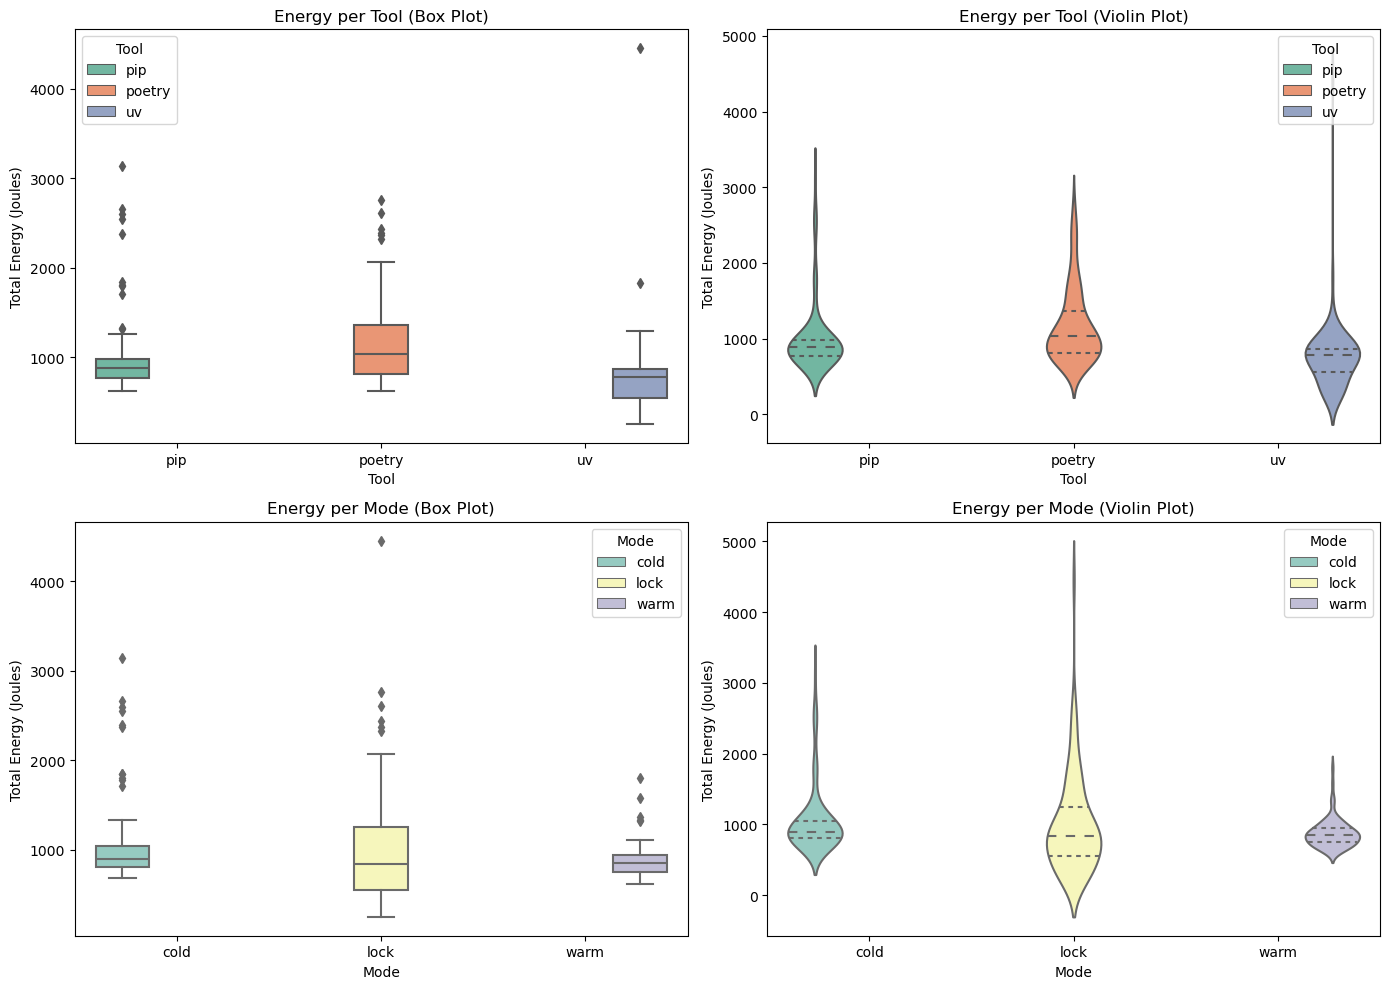

In [3]:
plt.figure(figsize=(14, 10))

# Top Row: Grouped by Tool
plt.subplot(2, 2, 1)
sns.boxplot(data=df_summary, x='Tool', y='Total_Energy_J', hue='Tool', palette="Set2")
plt.title('Energy per Tool (Box Plot)')
plt.ylabel('Total Energy (Joules)')

plt.subplot(2, 2, 2)
sns.violinplot(data=df_summary, x='Tool', y='Total_Energy_J', hue='Tool', palette="Set2", inner="quartile")
plt.title('Energy per Tool (Violin Plot)')
plt.ylabel('Total Energy (Joules)')

# Bottom Row: Grouped by Mode
plt.subplot(2, 2, 3)
sns.boxplot(data=df_summary, x='Mode', y='Total_Energy_J', hue='Mode', palette="Set3")
plt.title('Energy per Mode (Box Plot)')
plt.ylabel('Total Energy (Joules)')

plt.subplot(2, 2, 4)
sns.violinplot(data=df_summary, x='Mode', y='Total_Energy_J', hue='Mode', palette="Set3", inner="quartile")
plt.title('Energy per Mode (Violin Plot)')
plt.ylabel('Total Energy (Joules)')

plt.tight_layout()
plt.show()

In [4]:
print("Shapiro-Wilk Test for Normality")
print("Null hypothesis: The data is normally distributed (p > 0.05)\n")

print("--- By Tool ---")
for tool in df_summary['Tool'].unique():
    data = df_summary[df_summary['Tool'] == tool]['Total_Energy_J']
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
        print(f"{tool: <8} | W={stat:.4f}, p={p:.4f}")

print("\n--- By Mode ---")
for mode in df_summary['Mode'].unique():
    data = df_summary[df_summary['Mode'] == mode]['Total_Energy_J']
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
        print(f"{mode: <8} | W={stat:.4f}, p={p:.4f}")

print("Conclusion: Data is not normally distributed")

Shapiro-Wilk Test for Normality
Null hypothesis: The data is normally distributed (p > 0.05)

--- By Tool ---
pip      | W=0.5971, p=0.0000
poetry   | W=0.8365, p=0.0000
uv       | W=0.5698, p=0.0000

--- By Mode ---
cold     | W=0.6376, p=0.0000
lock     | W=0.8285, p=0.0000
warm     | W=0.8406, p=0.0000
Conclusion: Data is not normally distributed


In [5]:
def run_mannwhitney_test(df, column_name, group_a, group_b):
    data_a = df[df[column_name] == group_a]['Total_Energy_J']
    data_b = df[df[column_name] == group_b]['Total_Energy_J']
    
        
    u_stat, p_val = stats.mannwhitneyu(data_a, data_b, alternative='two-sided')
    
    print(f"Mann-Whitney U Test: {group_a} vs {group_b}")
    print(f"  U-statistic : {u_stat:.4f}")
    print(f"  p-value     : {p_val:.4e}")
    print(f"  Significant?: {'Yes' if p_val < 0.05 else 'No'}\n")

print("Mann-Whitney U Tests (Comparing Tools)")
run_mannwhitney_test(df_summary, 'Tool', 'pip', 'uv')
run_mannwhitney_test(df_summary, 'Tool', 'pip', 'poetry')
run_mannwhitney_test(df_summary, 'Tool', 'uv', 'poetry')

print("Mann-Whitney U Tests (Comparing Modes)")
run_mannwhitney_test(df_summary, 'Mode', 'cold', 'warm')
run_mannwhitney_test(df_summary, 'Mode', 'lock', 'warm')
run_mannwhitney_test(df_summary, 'Mode', 'lock', 'cold')

Mann-Whitney U Tests (Comparing Tools)
Mann-Whitney U Test: pip vs uv
  U-statistic : 5721.0000
  p-value     : 3.9860e-06
  Significant?: Yes

Mann-Whitney U Test: pip vs poetry
  U-statistic : 3010.0000
  p-value     : 2.9400e-03
  Significant?: Yes

Mann-Whitney U Test: uv vs poetry
  U-statistic : 1806.0000
  p-value     : 8.3989e-11
  Significant?: Yes

Mann-Whitney U Tests (Comparing Modes)
Mann-Whitney U Test: cold vs warm
  U-statistic : 5106.0000
  p-value     : 2.5301e-03
  Significant?: Yes

Mann-Whitney U Test: lock vs warm
  U-statistic : 3981.0000
  p-value     : 7.4742e-01
  Significant?: No

Mann-Whitney U Test: lock vs cold
  U-statistic : 3303.0000
  p-value     : 2.4719e-02
  Significant?: Yes

